<center>
<p><img src="https://mcd.unison.mx/wp-content/themes/awaken/img/logo_mcd.png" width="150">
</p>



<h1>Curso Ingeniería de Características</h1>

<h3>Datos numéricos</h3>


<p> Julio Waissman Vilanova </p>
<p>
<img src="https://identidadbuho.unison.mx/wp-content/uploads/2019/06/letragrama-cmyk-72.jpg" width="150">
</p>


<a target="_blank" href="https://colab.research.google.com/github/mcd-unison/ing-caract/blob/main/ejemplos/tipos/python/numericos.ipynb"><img src="https://i.ibb.co/2P3SLwK/colab.png"  style="padding-bottom:5px;"  width="30" /> Ejecuta en Colab</a>

</center>

In [2]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import urllib.request

## Descargando datos

Para poder descargar los datos que vamos a utilizar, vamos a requerir el módulo de ``kaggle``. Por lo que vamos a [seguir estos pasos](https://www.kaggle.com/general/74235) para usar correctamente la API de Kaggle en Colab.

In [3]:
!pip install -q kaggle

from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"juliowaissman","key":"f44e496038c88a021f1371f72ad5d649"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Y ahora probamos que todo funciona bien, al ver la lista de datasets
!kaggle datasets list

ref                                                            title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
iamsouravbanerjee/house-rent-prediction-dataset                House Rent Prediction Dataset                        82KB  2022-08-20 13:49:03           5786        187  1.0              
deepcontractor/mcdonalds-india-menu-nutrition-facts            McDonald's India : Menu Nutrition Dataset             5KB  2022-07-28 17:08:52           4944        178  0.9411765        
arianazmoudeh/airbnbopendata                                   Airbnb Open Data                                     10MB  2022-08-01 15:58:10           3136         94  0.9705882        
iamsouravbanerjee/world-population-dataset                     Wo

Y listo, vamos a descargar nuestro conjunto de datos

In [5]:
!kaggle datasets download 'camnugent/california-housing-prices'


  0% 0.00/400k [00:00<?, ?B/s]
100% 400k/400k [00:00<00:00, 34.2MB/s]


Los datos se encuentran en archivo comprimido, pero es un `csv`, por lo que lo podemos abrir directamente en Pandas.

In [6]:
df_raw = pd.read_csv("./california-housing-prices.zip")

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## Explorando los datos

Vamos a ver como se comportan cada una de las variables y para esto vamos a usar diferentes métodos de graficación que vienen incluidos en Pandas.

Lo primero que vamos a hacer va a ser revisar las estadísticas básicas de cada variables.

In [7]:
df_raw.describe(include='float64')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Pero esto no nos da toda la información necesaria, por lo que tenemos que revisar cada una de las variables. 

Vamos a usar un *histograma* para ver como se distribuyen los valores de las diferentes variables.

Revisa para cada variable numérica que tenemos.

Histograma



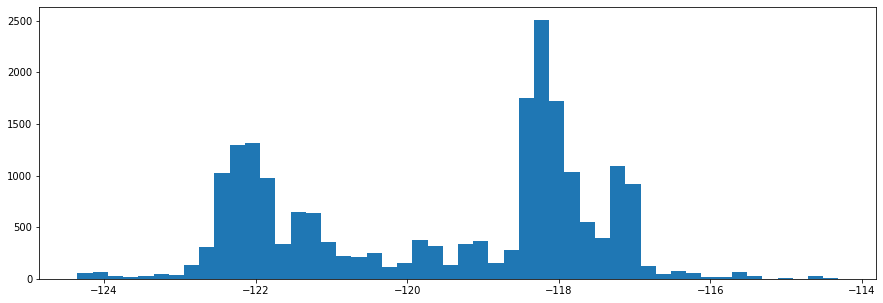

In [8]:
df_raw.longitude.hist(bins=50, grid=False, figsize=(15, 5))
print("Histograma\n")

Si quieres ver todas juntas (aunque no muy claro es una ayuda, se puede hacer el histograma de todas las variables numéricas con el siguiente pedazo de codigo:

Histogramas



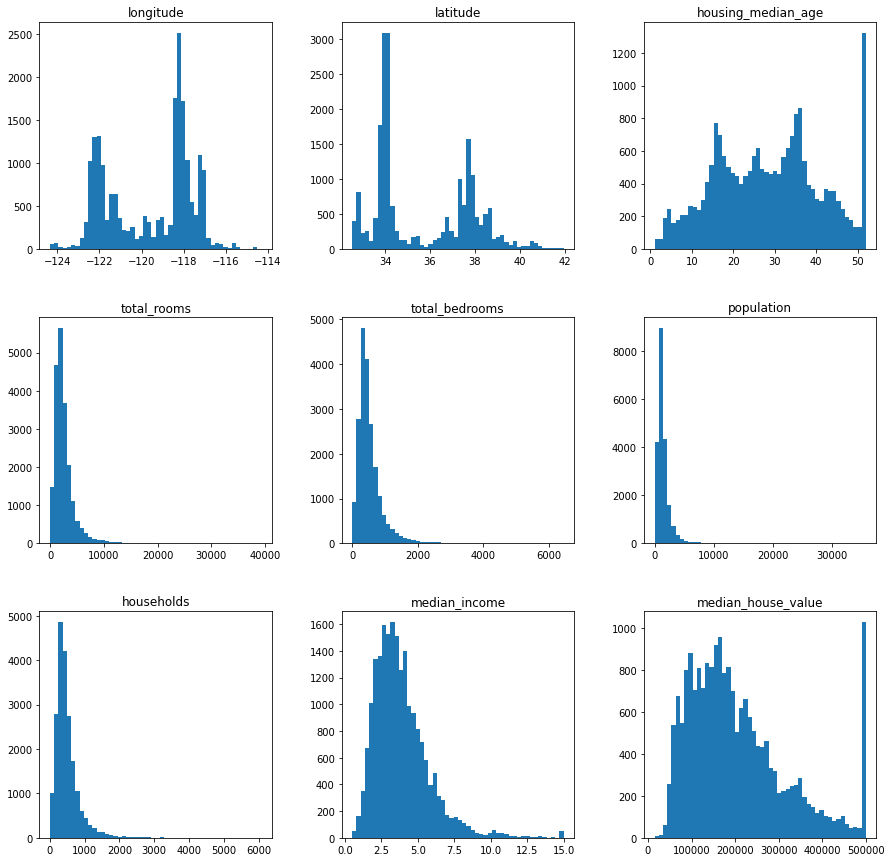

In [9]:
hists = df_raw.hist(bins=50, grid=False, figsize=(15, 15))
print("Histogramas\n")

## Tratamiento de las variables

Vamos a modificar las variables pensando en que las vamos a utilizar para desarrollar modelos de regresión y/o clasificacion, y vamos a revisar algunas técnicas.

Vamos a ir desarrollandolas paso a paso y vamos a tratar de dilucidar entre todos cual es la mejor opción para cada variables.

Recuerda, es importante saber para que lo quieres, y que técnica vas a utilizar, pero hay algunas cosas que son muy importantes para casi todo algoritmo que optimiza parámetros de un modelo basado en datos:

1. Los datos que tienen media 0 facilitan mucho el actuar de los algoritmos de optimización.

2. Tener variables que sean *adimensionales* y todas en los mismos rangos facilita el aprendizaje o el uso de métodos estadísticos (sobre todo la parte numérica pero no solamente).

3. El escalamiento facilita mucho el preprocesamiento.

4. La transformación de datos en muchas ocasiones **es parte del modelo**. El escalamiento o la transformación de variables numéricas se realiza desde la limpieza de datos, pero son al fin de cuenta modelos donde se guardan parámetros. Es una de las principales fuentes de error de muchos desarrollos tecnológicos (mas de los que podría uno creer).

5. Es importante asegurarse que no hay valores faltantes, o que los algoritmos que utilicemos sean capaces de lidiar con valores faltantes.

In [10]:
# Vamos a quedarnos con las variables numéricas solamente
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df = df_raw.select_dtypes(include=numerics).copy()

#cambia los valores perdidos por 0 en todas las variables
df.fillna(0, inplace=True)

### Escalamiento

El escalamiento de puede hacer de tres maneras básicas:

1. *MinMax* 
2. *MaxAbs*
3. *Z-score* o *estandarización*


**Ejercicio: ¿Cuales variables serían las mejor adaptadas para utilizar un escalamiento simple? Revisa que pasa con diferentes variables. Escribe aquí cuales variables parecen beneficiarse de un escalamiento de este tipo y cuales no, agrega aqui abajo tus comentarios**

Histogramas de acuerdo a 3 tipos de escalamiento



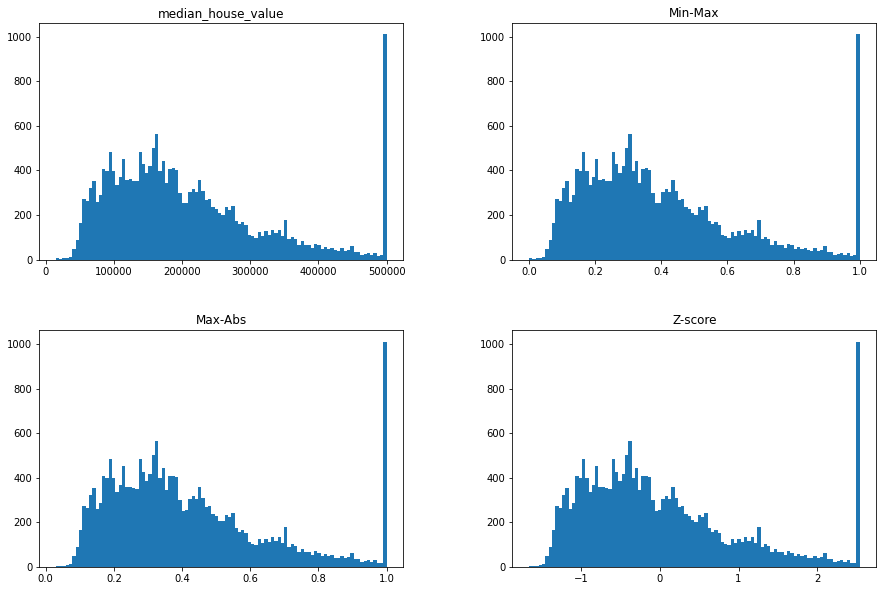

In [11]:
scalers = [
    preprocessing.MinMaxScaler(),
    preprocessing.MaxAbsScaler(),
    preprocessing.StandardScaler()
]
nombres = ['Min-Max', 'Max-Abs', 'Z-score']

variable = 'median_house_value'
df_scalers = df.loc[:, [variable]]

for (nombre, scaler) in zip(nombres, scalers):
    df_scalers[nombre] = scaler.fit_transform(
        df_scalers[variable].values.reshape(-1,1)
    )

df_scalers.hist(bins=100, grid=False, figsize=(15, 10))
print("Histogramas de acuerdo a 3 tipos de escalamiento\n")

### Transformaciones logarítmicas

En muchas ocasiones hay variables con comportamientos parecidos a la exponencial, por lo que un pretratamiento con el logaritmo suele mejorar mucho la distribucion de los datos.

**Ejercicio: ¿En este caso en que variables podría aplicar una transformación logarítmica? ¿Se podría una transformación diferente (i.e. raiz cuadrada o cuadrado)? ¿En que casos? Agrumenta tu respuesta aqui mismo**



Logarítmica



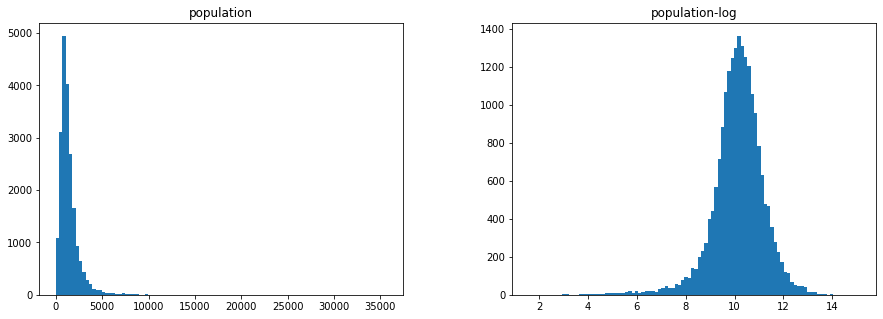

In [12]:
variable = 'population'
nueva = variable + "-log"

df[nueva] = np.log(df[variable].values)/np.log(2)

df[[variable, nueva]]\
    .hist(bins=100, grid=False, figsize=(15, 5))

print("Logarítmica\n")

### Transformación por mapeo a una distribución normal

Los métodos principales para una transformación no lineal, con el fin que los datos se asemejen a una distribución normal son los sguientes:

- Método de [Box-Cox](http://www.econ.illinois.edu/~econ508/Papers/boxcox64.pdf). El tradicional, pero que sólo se usa en variables con valores positivos.
- Método de [Yeo-Johnson](https://link.springer.com/article/10.1007/s10994-021-05960-5). En el enlace hablan del método como el método básico y proponen otro método, se ve interesante pero solo le di una lectura muy superficial.
- Método de [Transformación por función de quantil](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2921808/). Algo complicado y no se que tan buenos resultados tenga para preprocesar datos para entrenamiento de modelos.

¿Que tan bien funcionan los diferentes métodos para modificar variables antes de un proceso de aprendizaje? En [este artículo](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwipwtHCuPL5AhVgC0QIHRLMAEcQFnoECAYQAQ&url=https%3A%2F%2Fwww.mdpi.com%2F2227-7080%2F9%2F3%2F52%2Fpdf%3Fversion%3D1627349465&usg=AOvVaw2j6S3Ho-qTSauAFL6Euldu) hicieron algunos experimentos.


Histogramas de acuerdo a 3 tipos de transformación a distribución normal



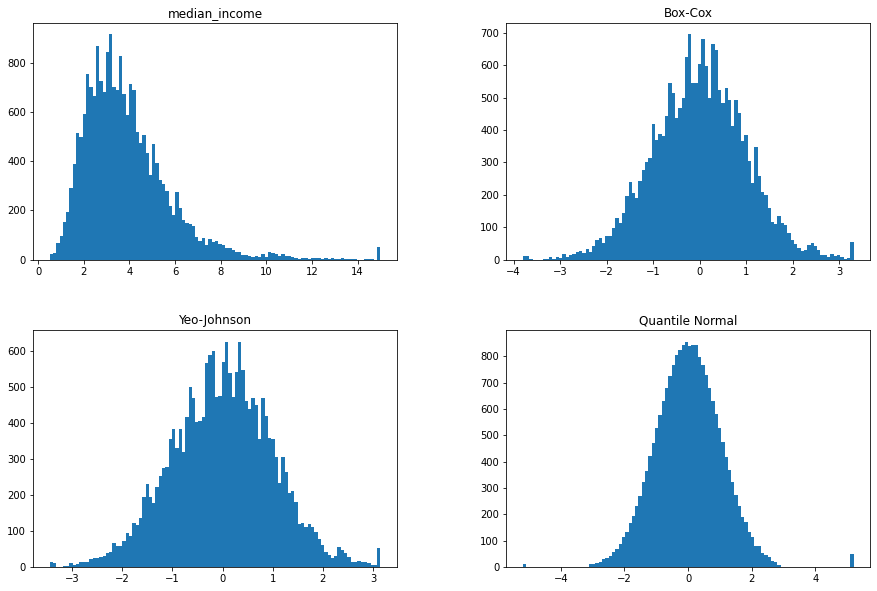

In [14]:
normal_dist = [
    preprocessing.PowerTransformer(method='box-cox'),
    preprocessing.PowerTransformer(),
    preprocessing.QuantileTransformer(output_distribution='normal')
]
nombres = ['Box-Cox', 'Yeo-Johnson', 'Quantile Normal']

variable = 'median_income'
df_transformer = df.loc[:, [variable]]

for (nombre, transformer) in zip(nombres, normal_dist):
    df_transformer[nombre] = transformer.fit_transform(
        df_transformer[variable].values.reshape(-1,1)
    )

df_transformer.hist(bins=100, grid=False, figsize=(15, 10))
print("Histogramas de acuerdo a 3 tipos de transformación a distribución normal\n")

**Ejercicio: Revisa con las diferentes variables cuales se podrían ver beneficiadas de una de estas transformaciones y cuales no. Escribe tu respuesta y argumenta tus resultados aquí mismo**

## Discretización

Tambien conocida como *bucketting* o *binning* es un método para convertir una variable numérica en discreta por regiones. 

¿Y para qué quisiersamos discretizar una variables? Porque hay casos donde las variables en forma numérica no nos permiten extraer fácilmente características importantes. Esto es particularmente cierto en variables con una distribución multimodal.

Por ejemplo, veamos la variable *latitude*:


Histograma



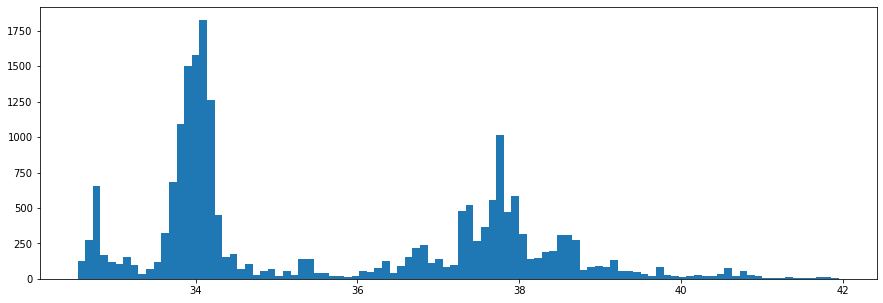

In [15]:

df_raw.latitude.hist(bins=100, grid=False, figsize=(15, 5))
print("Histograma\n")

Podemos ver como hay varios picos. Si revisamos un poco, vemos que los picos representan las latitudes de diferentes ciudades grandes de California. Esto implica que nuestro dato numñerico, en realidad está representando una situación que es de orden cualitativo.

Hacer *binning* implica prácticamente separar en intervalos los datos y asignarles un valor cualitativo a cada uno. Esta separación de puede hacer de 3 tipos:

1. Por intervalos uniformes
2. Por cuantiles
3. Por algun método de aprendizaje no supervisado (K-medias es el más sencillo de implementar).

Vamos a ver las diferencias entre los tres métodos:

In [20]:

nbins = 7
estrategias = ['uniform', 'quantile', 'kmeans']
binarizers = [
    preprocessing.KBinsDiscretizer(
        n_bins=nbins, encode='ordinal', strategy=estrategia
    )
    for estrategia in estrategias]

variable = 'latitude'
df_bin = df[[variable]].copy()

for (estrategia, binarizer) in zip(estrategias, binarizers):
  df_bin[estrategia] = binarizer.fit_transform(
      df_bin[variable].values.reshape(-1,1)
  )

Si no le dices que la codificación es `ordinal`, entonces te lo genera como codificación `one-hot` (que vamos a ver en el manejo de datos cualitativos).

Por ejemplo:

In [109]:
a = preprocessing.KBinsDiscretizer(n_bins=3, strategy='kmeans')\
    .fit_transform(df_bin.latitude.values.reshape(-1,1))

print("Un pedazo del resultado (que se encuentra como matriz dispersa)")
print(a[11700:11710,:].toarray())

print("\nNúmero de casos por bin (o bucket)")
a.sum(axis=0)

Un pedazo del resultado (que se encuentra como matriz dispersa)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]

Número de casos por bin (o bucket)


matrix([[11764.,  6448.,  2428.]])

Aqui podemos ver como nos quedo la binarizacion:

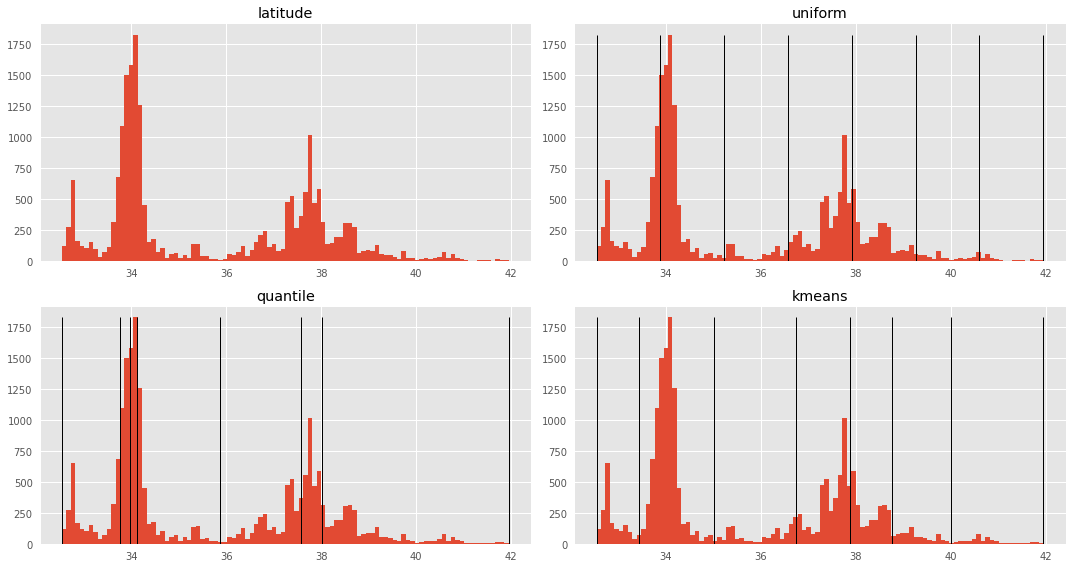

In [88]:
# Esto es pura graficación

import matplotlib.pyplot as plt
plt.style.use('ggplot')
fig, axs = plt.subplots(2, 2, tight_layout=True, figsize= (15, 8)) 

for i in range(4):
  ax = plt.subplot(2, 2, i+1)
  N, bins, patches = ax.hist(df_bin[variable], bins=100)
  if i > 0:
    ax.vlines(binarizers[i-1].bin_edges_[0], 0, N.max(), lw=1)
  #ax.grid(0) 
  plt.title(df_bin.columns[i])
  #plt.ylabel('Counts')
  #plt.xlabel(variable)
plt.show()

**Ejercicio: ¿Qué pasa si aumentan los *buckets* a 50 por ejemplo? ¿Porqué crees que es mejor mantener un número pequeño de *buquets*? ¿En que variables crees que podría haber una ventaja si se binariza? ¿Porqué? Escribe aqui mismo tus respuestas.**